<a href="https://colab.research.google.com/github/Chaitanyaa/ML-CIFAR100/blob/master/Copy2_Cifar10_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10 image identification with Neural Networks

In [1]:
# install keras first

!pip install dill
!pip install -q keras

In [0]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"


In [3]:
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

Using TensorFlow backend.


In [4]:
batch_size = 3
num_classes = 1
'''
epochs_longrun = 500
save_dir = "/work"
res_dir = "/results"
model_name = 'convnet_cifar100'
'''

'\nepochs_longrun = 500\nsave_dir = "/work"\nres_dir = "/results"\nmodel_name = \'convnet_cifar100\'\n'

In [0]:
from keras.datasets import cifar100

In [0]:
from __future__ import print_function
import tensorflow as tf
import keras
#from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical
from keras.models import load_model

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import warnings
warnings.filterwarnings('ignore')

In [35]:
tf.reset_default_graph()
tf.set_random_seed(343)
np.random.seed(343)
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


In [0]:
import matplotlib.pyplot as plt

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    #rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    rst = r * data[:, 0, :, :] + g * data[:, 1, :, :] + b * data[:, 2, :, :]
    # add channel dimension
    rst = np.expand_dims(rst, axis=1)
    return rst

x_train = grayscale(x_train)
x_test = grayscale(x_test)

### Prediction with Random Forest/try svm and see whats your result

In [0]:
# #Let's see how good is RandomForest
# # from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# # logit = RandomForestClassifier()
# tree = DecisionTreeClassifier()
# # knn = KNeighborsClassifier()
# x_train_1 = x_train.reshape(x_train.shape[0],3*32*32)
# x_test_1 = x_test.reshape(x_test.shape[0],3*32*32)
# tree.fit(x_train_1, y_train)
# # logit.fit(x_train_1, y_train)
# print ("Decision Tree Accuracy: {}%".format(tree.score(x_test_1, y_test)*100))

## Prediction with Feedforward Neural Networks

In [0]:
# #Let's review how MLPClassifier got trained and do prediction
# from sklearn.neural_network import MLPClassifier
# mlp = MLPClassifier(hidden_layer_sizes=(100), activation='relu')
# mlp.fit(x_train_1, y_train)
# score =mlp.score(x_test_1, y_test)
# print('MLP NN score: %.2f%%' %(score*100))

In [0]:
# Let's see what values are in the label y_train
# np.unique(y_train)

## Combining the training and test data back into one data

In [40]:
x = np.concatenate((x_train,x_test))
y = np.concatenate((y_train,y_test))
print('x shape:', x.shape)
print('y shape:', y.shape)

x shape: (60000, 1, 32, 32)
y shape: (60000, 1)


In [0]:
# Required subset of data in dataframe
x = x.reshape(x.shape[0],32*32)
images_df = pd.DataFrame(x, columns = list(range(0,1024)))
temp = pd.DataFrame(y, columns = ['Target'])
images_df = pd.concat([images_df,temp],axis=1)

In [42]:
images_df[(images_df['Target']==18) | (images_df['Target']==19) ].shape

(1200, 1025)

In [43]:
vehicle_images = images_df[(images_df['Target']==18) | (images_df['Target']==19) ]
vehicle_images.shape

(1200, 1025)

In [0]:
x = vehicle_images.drop(['Target'],axis=1).values
y = vehicle_images['Target'].values
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=42)
y_train_c = pd.get_dummies(y_train,drop_first=True)
y_test_c = pd.get_dummies(y_test,drop_first=True)
#Normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

## Image identification with CNN

In [0]:
x_train = x_train.reshape(x_train.shape[0],1,32,32)
x_test = x_test.reshape(x_test.shape[0],1,32,32)

In [0]:
model = Sequential()

model.add(Conv2D(48, kernel_size=(3, 3), activation='relu',
                 input_shape=x_train.shape[1:]))
model.add(Conv2D(48, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(1))

model.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))


opt = Adam(lr=0.00005, decay=1e-6)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
# model = Sequential()

# model.add(Conv2D(48, kernel_size=(3, 3), activation='relu',
#                  input_shape=x_train.shape[1:]))
# model.add(Conv2D(48, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(1))

# model.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='relu'))


# opt = Adam(lr=0.00005, decay=1e-6)

# model.compile(loss='binary_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy'])

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 30, 30)        480       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 28, 28)        20784     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 14, 14)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 12, 12)        41568     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 96, 6, 6)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 4, 4)          83040     
__________

In [49]:
print('Using real-time data augmentation.')

datagen = ImageDataGenerator(
	featurewise_center=False, 
	samplewise_center=False,  
	featurewise_std_normalization=False,
	samplewise_std_normalization=False, 
	zca_whitening=False, 
	rotation_range=0, 
	width_shift_range=0.1, 
	height_shift_range=0.1,
	horizontal_flip=True, 
	vertical_flip=False) 

datagen.fit(x_train)

Using real-time data augmentation.


In [50]:
#Let's train the model
epochs = 10
hist = model.fit_generator(datagen.flow(x_train, y_train_c,
    batch_size=batch_size,shuffle=True),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test_c),
    workers=4)

Epoch 1/10
300/300 [==============================] - 2s 7ms/step - loss: 8.1483 - acc: 0.4889 - val_loss: 7.4398 - val_acc: 0.5333
Epoch 2/10
300/300 [==============================] - 2s 6ms/step - loss: 8.1483 - acc: 0.4889 - val_loss: 7.4398 - val_acc: 0.5333
Epoch 3/10
300/300 [==============================] - 2s 6ms/step - loss: 8.1483 - acc: 0.4889 - val_loss: 7.4398 - val_acc: 0.5333
Epoch 4/10
300/300 [==============================] - 2s 6ms/step - loss: 8.1483 - acc: 0.4889 - val_loss: 7.4398 - val_acc: 0.5333
Epoch 5/10
300/300 [==============================] - 2s 6ms/step - loss: 8.1483 - acc: 0.4889 - val_loss: 7.4398 - val_acc: 0.5333
Epoch 6/10
300/300 [==============================] - 2s 6ms/step - loss: 8.1483 - acc: 0.4889 - val_loss: 7.4398 - val_acc: 0.5333
Epoch 7/10
300/300 [==============================] - 2s 6ms/step - loss: 8.1483 - acc: 0.4889 - val_loss: 7.4398 - val_acc: 0.5333
Epoch 8/10
300/300 [==============================] - 2s 6ms/step - loss: 8.

In [47]:
scores = model.evaluate(x_test, y_test_c, verbose=0)
print("CNN score: %.2f%%" % (scores[1]*100))

CNN score: 72.67%


In [0]:
# To view sample data B/w

#Manipulation to get the required shape
temp =  vehicle_images[vehicle_images['Target']==18].sample(16)
temp = temp.iloc[:,:-1].values
temp = temp.reshape(16,1,32,32)

# plot a randomly chosen image
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
k=1
for i in list(range(0,16)):
  #plt.figure(figsize=(4, 2))
  ax = fig.add_subplot(4, 4, k)
  fig.set_tight_layout(True) 
  ax = plt.imshow(temp[i, 0, :, :], cmap=plt.get_cmap('gray'), interpolation='none')
  k = k+1

In [0]:
#print out randomly selected images(black/red labl-->correct/wrong prediction )
def cifar_grid_c(X,Y,inds,n_col, predictions=None):
  if predictions is not None:
    if Y.shape != predictions.shape:
      print("Predictions must equal Y in length!")
      return(None)
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig, axes = plt.subplots(n_row,n_col,figsize=(10,10))
  
#  clabels = labels["label_names"]
  clabels = ['vehicle 1', 'vehicle 2']
  print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
      
     # axes[j][k].set_axis_off()
      if i_inds < N:
        rgb = X[[i_data,...]]
        #print(rgb.shape)
        img = rgb.reshape(1,32,32).transpose([1, 2, 0])
        axes[j][k].imshow(img, interpolation='nearest')
        label = clabels[np.argmax(Y[i_data,...])]
        axes[j][k].set_title(label)
        if predictions is not None:
          pred = clabels[np.argmax(predictions[i_data,...])]
          if label != pred:
            label += " n"
            axes[j][k].set_title(pred, color='red')            
  
  fig.set_tight_layout(True)

<class 'list'>


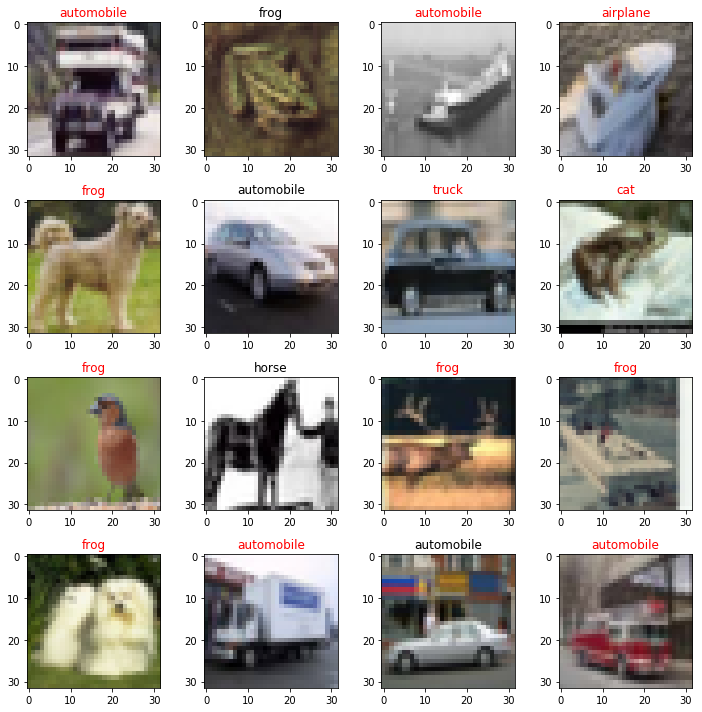

In [0]:
num_predictions = 16
predict_gen = model.predict_generator(datagen.flow(x_test, y_test_c,
    batch_size=batch_size, shuffle=False),
    steps=(x_test.shape[0] // batch_size)+1, workers=4)

indices = [np.random.choice(range(len(x_test))) 
           for i in range(num_predictions)]

cifar_grid_c(x_test,y_test_c,indices,4, predictions=predict_gen)

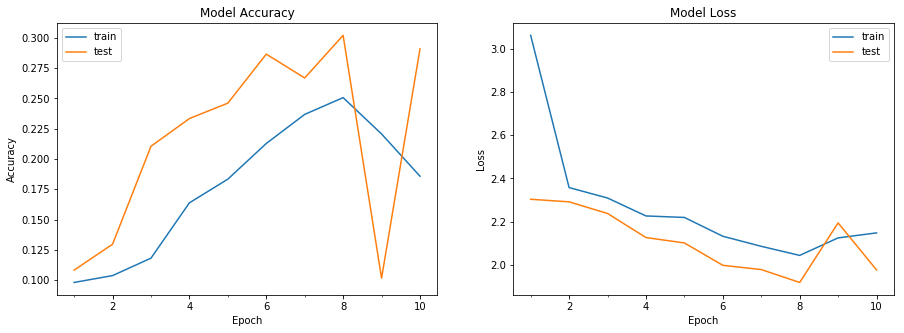

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'test'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'test'], loc='best')
    plt.show()
plot_model_history(hist)
    


In [0]:
import dill as pickle
with open("hist_path", 'wb') as f:
    pickle.dump(hist.history, f)

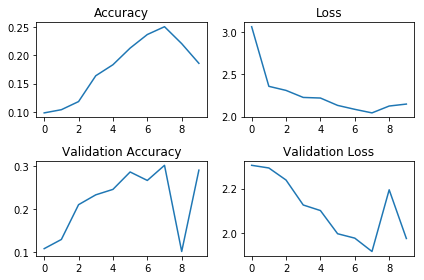

In [0]:
key2name = {'acc':'Accuracy', 'loss':'Loss', 
    'val_acc':'Validation Accuracy', 'val_loss':'Validation Loss'}
with open("hist_path", 'rb') as f:
  hist = pickle.load(f)
fig = plt.figure()

things = ['acc','loss','val_acc','val_loss']
for i,thing in enumerate(things):
  trace = hist[thing]
  plt.subplot(2,2,i+1)
  plt.plot(range(len(trace)),trace)
  plt.title(key2name[thing])

fig.set_tight_layout(True)
# fig